In [1]:
IMG_WIDTH = 500                                 # in pixels
IMG_HEIGTH = 200                                # in pixels
CROPPED = True                                  # TRUE: the images will be cropped to the spectrum only.
                                                # FALSE: The images will contain axis descriptions and a legend
SPECTRUM_FOLDERNAME = 'spectrums_grayscale' # this folder will be created if it doesnt exists
CSV_FILENAME = 'data_balanced_processed_new.csv'    # the csv file, containing spectrum filenames and audio features, that will be saved

In [2]:
import pandas as pd
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

data_path = os.path.join('..', 'Datasets')
audio_path = os.path.join(data_path, 'groove')
spectrum_path = os.path.join(data_path, SPECTRUM_FOLDERNAME)
meta_data_file = os.path.join("data_balanced.csv")

data = pd.read_csv(meta_data_file, encoding="latin-1")
data.head()

,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split,start,end,times_sampled,possible_samples,oversampling_ratio
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,funk,138,1,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test,11.692,14.692,2,2.645385,0.215267
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,funk,102,1,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test,25.264,28.264,2,4.281860,0.159189
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,funk,105,1,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test,10.130,13.130,3,3.058536,0.247585
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,funk,86,1,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test,37.015,40.015,3,4.452757,0.201268
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,funk,80,1,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test,18.449,21.449,2,5.997917,0.125033


# Spectograms

In [3]:
import ast
import sys
np.set_printoptions(threshold=sys.maxsize)

def string_to_array(string):
    string = string.replace('[', '').replace(']', '')
    string = string.replace('\n', ' ')
    return np.fromstring(string, sep=' ', dtype = np.float64)

def reshape_melspectogram(array):
    return array.reshape(128,259)

def generate_spectogram(audio_filename, start, end, mel_spect):
    spectrum_filename = audio_filename.replace('.wav', '')
    spectrum_filename += f"_{start}-{end}.png"
    file_path = os.path.join(spectrum_path, spectrum_filename)
    
    if os.path.exists(file_path):
        print(f"File already: {file_path}")
        return spectrum_filename
    
    fig, ax = plt.subplots(figsize=(IMG_WIDTH / 100, IMG_HEIGTH / 100))

    #mel_spect = np.array(ast.literal_eval(mel_spect))
    librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time', cmap='gray')
    
    #librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    
    if(CROPPED):
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_axis_off()
        fig.subplots_adjust(left=0, bottom=0, right=0.1, top=0.1, wspace=0, hspace=0)
        plt.tight_layout(pad=0)
    else:
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.tight_layout()
    
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    plt.savefig(file_path, format='png')
    plt.close('all')
    #save_spectogram_image(S_db, sr, spectrum_path, cropped=cropped)
    return spectrum_filename

# Features

In [4]:
def array_to_string(array):
    return str(array).replace('\n', '')

def audio_feature_extraction(y, sr, stft, n_fft, hop_length):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
    
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    # Berechnung der Merkmale
    onset_env_mean = onset_env.mean()
    onset_env_std = onset_env.std()
    
    # Berechnen des STFT und des Spectral Flux
    #stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    spectral_flux = np.sqrt(np.mean((np.diff(stft, axis=1))**2, axis=0))
    spectral_flux_mean = spectral_flux.mean()
    spectral_flux_std = spectral_flux.std()
    
    bpm_extracted, beats = librosa.beat.beat_track(y=y, sr=sr, start_bpm=110, hop_length=hop_length)

    # Reduziere n_mels und passe fmax an, um leere Filter zu vermeiden
    n_mels = 40
    fmax = sr / 2
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)
    mfcc_mean = mfcc.mean()
    mfcc_std = mfcc.std()

    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectral_contrast_mean = spectral_contrast.mean()
    spectral_contrast_std = spectral_contrast.std()

    tonnetz = librosa.feature.tonnetz(y=y, sr=sr, hop_length=hop_length)
    tonnetz_mean = tonnetz.mean()
    tonnetz_std = tonnetz.std()

    rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    rms_mean = rms.mean()
    rms_std = rms.std()

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectral_centroid_mean = spectral_centroid.mean()
    spectral_centroid_std = spectral_centroid.std()

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectral_bandwidth_mean = spectral_bandwidth.mean()
    spectral_bandwidth_std = spectral_bandwidth.std()

    spectral_flatness = librosa.feature.spectral_flatness(y=y, n_fft=n_fft, hop_length=hop_length)
    spectral_flatness_mean = spectral_flatness.mean()
    spectral_flatness_std = spectral_flatness.std()

    tempogram = librosa.feature.tempogram_ratio(y=y, sr=sr)
    tempogram_mean = librosa.feature.tempogram_ratio(y=y, sr=sr).mean()
    tempogram_std = librosa.feature.tempogram_ratio(y=y, sr=sr).std()
    
    return {
        'onset_strengths': array_to_string(onset_env),
        'onset_frames': array_to_string(onset_frames),
        'melspectogram': mel_spect,
        'bpm_extracted': bpm_extracted[0],
        'onset_env_mean': onset_env_mean,
        'onset_env_std': onset_env_std,
        'spectral_flux_mean': spectral_flux_mean,
        'spectral_flux_std': spectral_flux_std,
        'mfcc_mean': mfcc_mean,
        'mfcc_std': mfcc_std,
        'spectral_contrast_mean': spectral_contrast_mean,
        'spectral_contrast_std': spectral_contrast_std,
        'tonnetz_mean': tonnetz_mean,
        'tonnetz_std': tonnetz_std,
        'rms_mean': rms_mean,
        'rms_std': rms_std,
        'spectral_centroid_mean': spectral_centroid_mean,
        'spectral_centroid_std': spectral_centroid_std,
        'spectral_bandwidth_mean': spectral_bandwidth_mean,
        'spectral_bandwidth_std': spectral_bandwidth_std,
        'spectral_flatness_mean': spectral_flatness_mean,
        'spectral_flatness_std': spectral_flatness_std,
        'tempogram_mean': tempogram_mean,
        'tempogram_std': tempogram_std
    }

In [5]:
def process_data(audio_filename, start, end):
    audio_path = os.path.join(data_path, 'groove', audio_filename)
    duration = end-start
    
    try:
        y, sr = librosa.load(audio_path, sr=44100, offset=start, duration=duration)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return
    
    # librosa magic
    n_fft = min(1024, len(y))
    hop_length = n_fft // 2
    stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    #S_db = librosa.amplitude_to_db(stft, ref=np.max)  # Konvertieren der Amplitude in Dezibel
    
    features = audio_feature_extraction(y, sr, stft, n_fft, hop_length)
    features['spectrum_filename'] = generate_spectogram(audio_filename, start, end, features['melspectogram'])
    features['melspectogram'] = array_to_string(features['melspectogram'])
    
    return pd.Series(features)

#### test code

# Processing

In [6]:
# progress bar for progress_appyly()
from tqdm.auto import tqdm
tqdm.pandas()

test_mask = data.audio_filename == 'drummer1/session1/145_latin-brazilian-baiao_95_beat_4-4.wav'

new_columns = [
    'onset_strengths', 'onset_frames', 'melspectogram', 'bpm_extracted',
    "onset_env_mean", "onset_env_std", "mfcc_mean", "mfcc_std", 
    "spectral_flux_mean", "spectral_flux_std", "spectral_contrast_mean", 
    "spectral_contrast_std", "tonnetz_mean", "tonnetz_std", "rms_mean", 
    "rms_std", "spectral_centroid_mean", "spectral_centroid_std", 
    "spectral_bandwidth_mean", "spectral_bandwidth_std", 
    "spectral_flatness_mean", "spectral_flatness_std", "tempogram_mean" ,"tempogram_std",
    "spectrum_filename"
]

In [7]:
data[new_columns] = data.progress_apply(lambda x: process_data(x.audio_filename, x.start, x.end), axis=1)
data.head(5)

  0%|          | 0/1200 [00:00<?, ?it/s]

File already: ..\Datasets\spectrums_grayscale\drummer1/eval_session/1_funk-groove1_138_beat_4-4_11.692-14.692.png
File already: ..\Datasets\spectrums_grayscale\drummer1/eval_session/10_soul-groove10_102_beat_4-4_25.264-28.264.png
File already: ..\Datasets\spectrums_grayscale\drummer1/eval_session/2_funk-groove2_105_beat_4-4_10.13-13.13.png
File already: ..\Datasets\spectrums_grayscale\drummer1/eval_session/3_soul-groove3_86_beat_4-4_37.015-40.015.png
File already: ..\Datasets\spectrums_grayscale\drummer1/eval_session/4_soul-groove4_80_beat_4-4_18.449-21.449.png
File already: ..\Datasets\spectrums_grayscale\drummer1/eval_session/5_funk-groove5_84_beat_4-4_30.59-33.59.png
File already: ..\Datasets\spectrums_grayscale\drummer1/eval_session/6_hiphop-groove6_87_beat_4-4_10.906-13.906.png
File already: ..\Datasets\spectrums_grayscale\drummer1/eval_session/7_pop-groove7_138_beat_4-4_6.057-9.057.png
File already: ..\Datasets\spectrums_grayscale\drummer1/eval_session/8_rock-groove8_65_beat_4-4_

,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,...,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_flatness_mean,spectral_flatness_std,tempogram_mean,tempogram_std,spectrum_filename
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,funk,138,1,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,...,0.056157,5608.665252,2501.480437,4647.658427,941.263597,0.090434,0.124045,0.294583,0.171183,drummer1/eval_session/1_funk-groove1_138_beat_...
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,funk,102,1,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,...,0.062846,7204.425221,3338.747216,5212.773742,1194.914650,0.148189,0.143111,0.267859,0.234713,drummer1/eval_session/10_soul-groove10_102_bea...
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,funk,105,1,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,...,0.061557,6172.809370,3874.975566,4711.894615,1483.392124,0.116454,0.132516,0.238676,0.153792,drummer1/eval_session/2_funk-groove2_105_beat_...
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,funk,86,1,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,...,0.053402,5704.099294,3309.100713,5098.568553,1251.293005,0.101191,0.128717,0.149444,0.144291,drummer1/eval_session/3_soul-groove3_86_beat_4...
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,funk,80,1,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,...,0.046688,8042.372855,3504.921958,5396.953176,999.442925,0.181278,0.149775,0.115379,0.128980,drummer1/eval_session/4_soul-groove4_80_beat_4...


#### check extracted bpm

In [29]:
abs(data.bpm - data.bpm_extracted).describe()

count    1200.000000
mean       28.951658
std        34.554756
min         0.000822
25%         1.167969
50%         5.029846
75%        53.813965
max       194.296875
dtype: float64

In [51]:
bpm_differences = abs(data.bpm - data.bpm_extracted)

In [37]:
bpm_differences.median()

5.029845698826115

The BPM estimation for 47% of the beats is off by 10 bpm or more. That a lot of bpm. Lets see how good the random forest will perform on that.

In [72]:
bpm_differences[bpm_differences > 10].count()/bpm_differences.count()

0.4766666666666667

<Axes: title={'center': 'Histogram of extracted and actual BPM differences'}, ylabel='Frequency'>

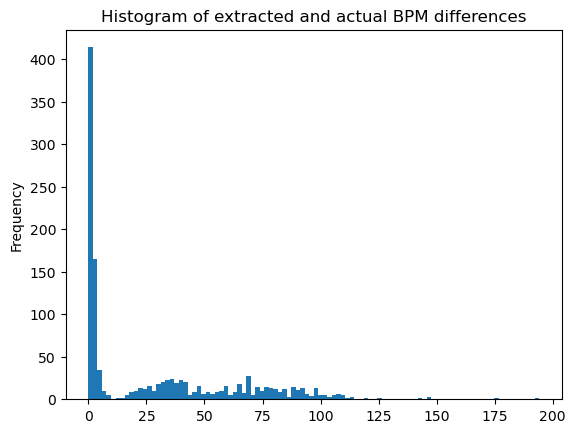

In [48]:
bpm_differences.plot.hist(bins=100, title='Histogram of extracted and actual BPM differences')

<Axes: title={'center': 'Boxplot of extracted and actual BPM differences'}>

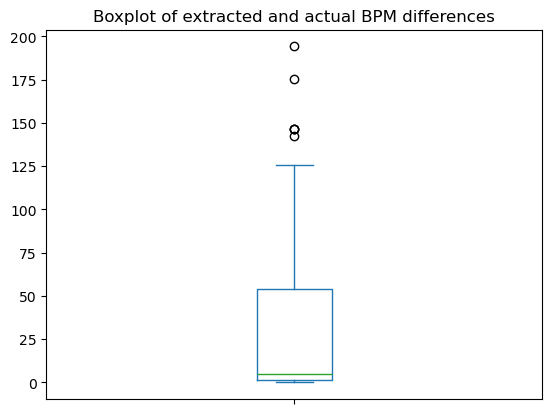

In [49]:
bpm_differences.plot.box(title='Boxplot of extracted and actual BPM differences')

<Axes: title={'center': 'Histogram of extracted BPM'}, ylabel='Frequency'>

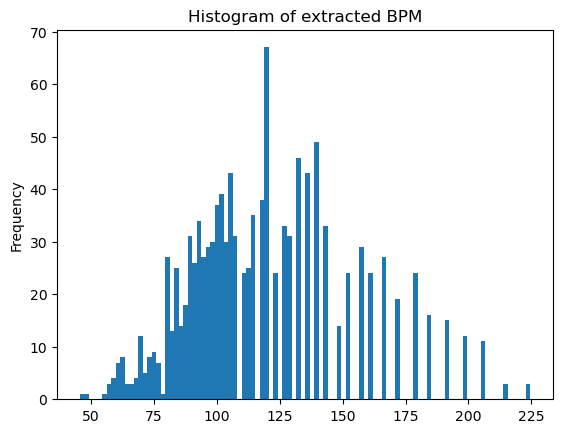

In [59]:
data.bpm_extracted.plot.hist(bins=100, title='Histogram of extracted BPM')

<Axes: ylabel='Frequency'>

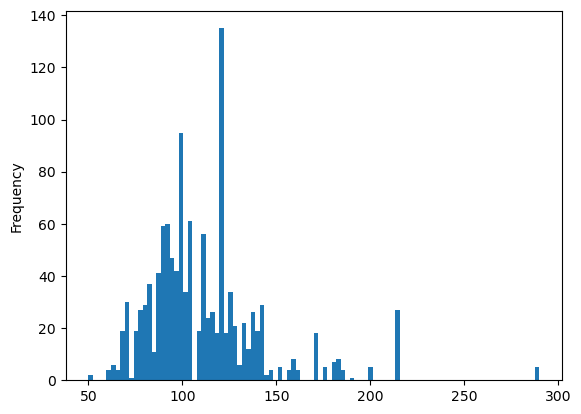

In [57]:
data.bpm.plot.hist(bins=100)

In [62]:
data.bpm.value_counts().sort_index()

bpm
50      2
60      4
63      2
64      4
65      4
       ..
185     4
190     1
200     5
215    27
290     5
Name: count, Length: 73, dtype: int64

In [65]:
data[data.bpm == 290].audio_filename.value_counts()

audio_filename
drummer1/session1/78_jazz-fast_290_beat_4-4.wav    5
Name: count, dtype: int64

#### saving

In [9]:
import sys

def array_to_string(array):
    return str(array).replace('\n', '')

def string_to_array(string):
    string = string.replace('[', '').replace(']', '')
    string = string.replace('\n', ' ')
    return np.fromstring(string, sep=' ', dtype = np.float64)

def reshape_melspectogram(array):
    return array.reshape(128,259)

def save_to_csv(data, filename):
    data['melspectogram'] = data['melspectogram'].apply(array_to_string)
    data['onset_strengths'] = data['onset_strengths'].apply(array_to_string)
    data['onset_frames'] = data['onset_frames'].apply(array_to_string)
    
    np.set_printoptions(threshold=sys.maxsize)
    data.to_csv(filename, index=False)

def load_from_csv(filename):
    data = pd.read_csv(filename)
    data['onset_strengths'] = data['onset_strengths'].apply(string_to_array)
    data['onset_frames'] = data['onset_frames'].apply(string_to_array)
    data['melspectogram'] = data['melspectogram'].apply(string_to_array).apply(reshape_melspectogram)
    
    return data

In [10]:
#save_to_csv(data, CSV_FILENAME)

In [11]:
np.set_printoptions(threshold=sys.maxsize)
data.to_csv(CSV_FILENAME, index=False)